# The Single-Diode Model

A simple yet effective model that is widely used to describe a solar cell is the Single-Diode Model (SDM). It is derived from physical principles and is represented by the following electric circuit:

<p align="center">
  <img src="https://pvpmc.sandia.gov/wp-content/uploads/2012/04/Single-Diode-EC2.png"
</p>

Without going into the details, the governing equation of the SDM is:

$$I = I_L - I_0[exp(\frac{V+IR_s}{nV_T})-1] - \frac{V+IR_s}{R_{sh}}$$

where $I_L$ is the light-induced current [A], $I_0$ the diode reverse saturation current [A], $R_s$ the series resistance [Ω], $R_{sh}$ the shunt resistance [Ω], and $n$ the ideality factor [unitless].

The thermal voltage $V_T = \frac{k_BT}{q}$ is simply the product of Boltzmann’s constant $k_B$ and the cell temperature $T$ divided by the elementary charge $q$.

The SDM can be used to determine the current-voltage (IV) curve of a solar cell under a given set of operating conditions (i.e. solar irradiance and cell temperature).

<p align="center">
  <img src="https://www.pveducation.org/sites/default/files/PVCDROM/Solar-Cell-Operation/Images/IV_curve_solar_cell.png"
</p>

If we assume that all the cells of a solar panel (PV module) comprising $N_s$ cells in series are identical and under uniform and equal irradiance and temperature (i.e. they generate the same current and voltage), we get $I_M = I_{cell}$ and $V_M = N_s × V_{cell}$, where $I_M$ and $V_M$ represent the module current and voltage, respectively. The governing equation becomes:

$$I_M = I_L - I_0[exp(\frac{V_M+I_MN_sR_s}{nN_sV_T})-1] - \frac{V_M+I_MN_sR_s}{N_sR_{sh}}$$

In this example, we will investigate the impact of the series $R_s$ and shunt  $R_{sh}$ resistances on the IV curve of a PV module. For simplicity, the photocurrent $I_L$, the saturation current $I_0$, and the $nN_sV_{th}$ product will be treated as fixed here.


**References:**

- https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/diode-equivalent-circuit-models/










## Import the libraries needed

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl

We will also need the _pvlib_ Python library, which is "a community supported tool that provides a set of functions and classes for simulating the performance of photovoltaic energy systems". 

In [2]:
!pip install pvlib
from pvlib import pvsystem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The values of the SDM parameters used in this example are inspired by the following _pvlib_ example: https://pvlib-python.readthedocs.io/en/v0.9.0/auto_examples/plot_singlediode.html#calculating-iv-curves

In [3]:
IL, I0, nNsVth = 5.3, 8.1e-08, 2.9

# Define the variable parameters
params = ['Rs', 'Rsh']

Rs = np.linspace(0.5, 5, 10)
Rsh = np.linspace(100, 1000, 10)

By sampling 10 values for each resistance, we get a total of 100 permutations.

## Simulate the IV curve of each ($R_s$ , $R_{sh}$) combination

In [4]:
combs = list(itertools.product(*[Rs, Rsh])) #all possible permutations of Rs and Rsh

index = pd.MultiIndex.from_tuples(combs, names=params)
iv_data = pd.DataFrame(index=index, columns = ['V', 'I', 'i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp']) 

for comb in combs:
  Rs, Rsh = comb

  curve_info = pvsystem.singlediode(photocurrent=IL,
                                  saturation_current=I0,
                                  resistance_series=Rs,
                                  resistance_shunt=Rsh,
                                  nNsVth=nNsVth, 
                                  ivcurve_pnts=100) #you can set the number of IV curve points based on the level of precision you need
  
  iv_data.loc[comb, 'V'] = curve_info['v'] #list of voltage points
  iv_data.loc[comb, 'I'] = curve_info['i'] #the current at each voltage point
  iv_data.loc[comb, 'i_sc'] = curve_info['i_sc']
  iv_data.loc[comb, 'v_oc'] = curve_info['v_oc']
  iv_data.loc[comb, 'i_mp'] = curve_info['i_mp']
  iv_data.loc[comb, 'v_mp'] = curve_info['v_mp']
  iv_data.loc[comb, 'p_mp'] = curve_info['p_mp']

## Visualize randomly selected IV curves

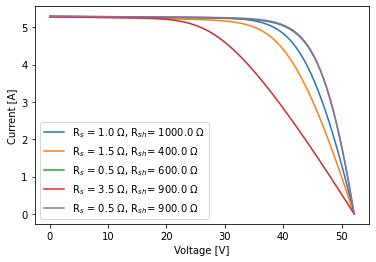

In [5]:
fig, ax = plt.subplots()
for comb in random.choices(combs, k=5):
  ax.plot(iv_data.loc[comb, 'V'], iv_data.loc[comb, 'I'], label=f'R$_s$ = {comb[0]} Ω' + ', R$_{sh}$' + f'= {comb[1]} Ω')
plt.legend()
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.show()

## Cluster the IV curves based on their $P_{MP}$ value

Feel free to change the number of clusters and IV curve property used to cluster the data.

In [6]:
n_clusters = 5
fitting_param = 'p_mp'

kmeans = KMeans(n_clusters=n_clusters).fit(iv_data[[fitting_param]])

iv_data['Cluster'] = kmeans.labels_
iv_data[['p_mp', 'Cluster']]

p_mp  Cluster
Rs  Rsh                        
0.5 100.0   189.671549        2
    200.0   198.350472        2
    300.0   201.257101        2
    400.0   202.712812        2
    500.0   203.586986        2
...                ...      ...
5.0 600.0   111.775835        1
    700.0   111.876418        1
    800.0   111.951644        1
    900.0   112.010027        1
    1000.0  112.056655        1

[100 rows x 2 columns]

## Cluster Stats

Find the percentage of IV curves included in each cluster and the $P_{MP}$ of the cluster centers. 

Since the cluster center is not necessarily a value from the data, find the IV curve with the closest $P_{MP}$ value.

You can also find the minimum and maximum values of $P_{MP}$ for each cluster.

In [7]:
clusters_info = pd.DataFrame(iv_data.value_counts('Cluster'), columns=['Nb of IV curves']).sort_index()

clusters_info['Share of IV curves'] = clusters_info['Nb of IV curves']/len(iv_data)

clusters_info[f'{fitting_param} of Center'] = kmeans.cluster_centers_

cluster_centers = []
for c in range(n_clusters):
  cluster_center = (iv_data[fitting_param] - kmeans.cluster_centers_[c]).abs().sort_values().index[0]
  cluster_centers.append(cluster_center)
clusters_info['Params of Center'] = cluster_centers

clusters_info

,Nb of IV curves,Share of IV curves,p_mp of Center,Params of Center
Cluster,,,,
0,20,0.20,174.575184,"(1.5, 200.0)"
1,21,0.21,115.588948,"(4.5, 100.0)"
2,19,0.19,197.083869,"(0.5, 200.0)"
3,20,0.20,153.101430,"(2.5, 200.0)"
4,20,0.20,133.358756,"(3.5, 100.0)"


Re-order the clusters in descending $P_{MP}$ order. 

In [8]:
clusters_info = clusters_info.sort_values(f'{fitting_param} of Center', ascending=False)

clusters_info['Ordered Cluster'] = range(n_clusters)

clusters_info

,Nb of IV curves,Share of IV curves,p_mp of Center,Params of Center,Ordered Cluster
Cluster,,,,,
2,19,0.19,197.083869,"(0.5, 200.0)",0
0,20,0.20,174.575184,"(1.5, 200.0)",1
3,20,0.20,153.101430,"(2.5, 200.0)",2
4,20,0.20,133.358756,"(3.5, 100.0)",3
1,21,0.21,115.588948,"(4.5, 100.0)",4


In [9]:
iv_data['Ordered Cluster'] = iv_data['Cluster'].replace(clusters_info.index, clusters_info['Ordered Cluster'])
iv_data[['p_mp', 'Cluster', 'Ordered Cluster']]

p_mp  Cluster  Ordered Cluster
Rs  Rsh                                         
0.5 100.0   189.671549        2                0
    200.0   198.350472        2                0
    300.0   201.257101        2                0
    400.0   202.712812        2                0
    500.0   203.586986        2                0
...                ...      ...              ...
5.0 600.0   111.775835        1                4
    700.0   111.876418        1                4
    800.0   111.951644        1                4
    900.0   112.010027        1                4
    1000.0  112.056655        1                4

[100 rows x 3 columns]

In [10]:
clusters_info = clusters_info.set_index('Ordered Cluster')
clusters_info

,Nb of IV curves,Share of IV curves,p_mp of Center,Params of Center
Ordered Cluster,,,,
0,19,0.19,197.083869,"(0.5, 200.0)"
1,20,0.20,174.575184,"(1.5, 200.0)"
2,20,0.20,153.101430,"(2.5, 200.0)"
3,20,0.20,133.358756,"(3.5, 100.0)"
4,21,0.21,115.588948,"(4.5, 100.0)"


Plot the IV curves corresponding to each cluster center.

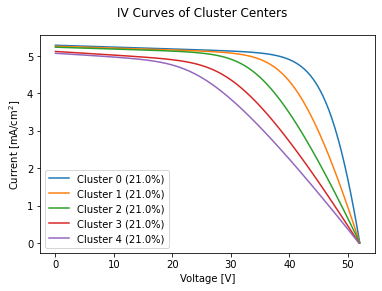

In [11]:
# Plot cluster centers
fig, ax = plt.subplots()
for cluster in range(n_clusters):
  cluster_params = clusters_info.loc[cluster, 'Params of Center']
  cluster_share = round(clusters_info.loc[c, 'Share of IV curves']*100, 1)
  ax.plot(iv_data.loc[cluster_params, 'V'], iv_data.loc[cluster_params, 'I'], label=f"Cluster {cluster} ({cluster_share}%)")
  ax.set_xlabel('Voltage [V]')
  ax.set_ylabel('Current [mA/cm$^2$]')
  fig.suptitle('IV Curves of Cluster Centers')
plt.legend()
plt.show()

## More Cluster Stats

Find how the parameter values are distributed among the clusters.

In [12]:
param_stats = pd.DataFrame([[iv_data.index.get_level_values(param).unique()] for param in params], columns=['Value'])
param_stats['param'] = params
param_stats = param_stats.explode('Value').set_index(['param', 'Value'])

for c in range(n_clusters):
    param_stats[f'Cluster {c}'] = 0
    iv_cluster = iv_data[iv_data['Ordered Cluster'] == c]
    for param in params:
        iv_cluster_counts = iv_cluster.index.get_level_values(param).value_counts()
        param_stats.loc[(param, iv_cluster_counts.index), f'Cluster {c}'] = iv_cluster_counts.values
        
param_stats

Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4
param Value                                                        
Rs    0.5            10          0          0          0          0
      1.0             9          1          0          0          0
      1.5             0         10          0          0          0
      2.0             0          9          1          0          0
      2.5             0          0         10          0          0
      3.0             0          0          9          1          0
      3.5             0          0          0         10          0
      4.0             0          0          0          9          1
      4.5             0          0          0          0         10
      5.0             0          0          0          0         10
Rsh   100.0           1          2          2          2          3
      200.0           2          2          2          2          2
      300.0           2          2          2          2          2
      400.0           2          2          2          2          2
      500.0           2          2          2          2          2
      600.0           2          2          2          2          2
      700.0           2          2          2          2          2
      800.0           2          2          2          2          2
      900.0           2          2          2          2          2
      1000.0          2          2          2          2          2

Normalize these stats

In [13]:
for param in params:
    param_counts = iv_data.index.get_level_values(param).value_counts()
    param_stats.loc[(param, param_counts.index), :] = param_stats.loc[(param, param_counts.index), :].div(param_counts.values, axis=0)*100

param_stats.head()

Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4
param Value                                                       
Rs    0.5        100.0        0.0        0.0        0.0        0.0
      1.0         90.0       10.0        0.0        0.0        0.0
      1.5          0.0      100.0        0.0        0.0        0.0
      2.0          0.0       90.0       10.0        0.0        0.0
      2.5          0.0        0.0      100.0        0.0        0.0

Each row adds up to 100% now. We can see that when $R_s = 0.5 Ω$, $P_{MP}$ is always in cluster 0, no matter how low $R_{sh}$ gets (within the previously specified range, of course).

## Visualize Cluster Stats

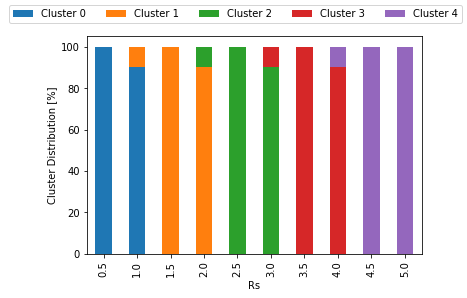

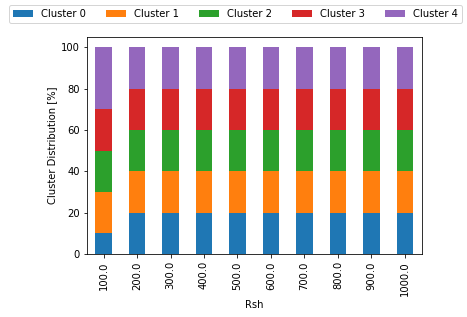

In [14]:
for i, param in enumerate(params):
    fig, ax = plt.subplots()
    param_stats.loc[param].plot.bar(ax=ax, stacked=True, legend=False)
    ax.set_xlabel(params[i])
    ax.set_ylabel('Cluster Distribution [%]')
    fig.legend(ncol=n_clusters)

As expected, the power output $P_{MP}$ is inversely proportional to the series resistance $R_s$. Generally speaking, having a higher shunt resistance $R_{sh}$ value increases your chances of getting a higher power output, but in this particular case, it is clear that the series resistance $R_s$ is the delimiting factor. 

If you want to better understand the relationship between these two resistances and their effect on the output power, you might want to take a look at the Bayesian inference tools included in the `bayes_inf` repo.



## Plot the IV curves of every cluster (the black curve being the cluster center)

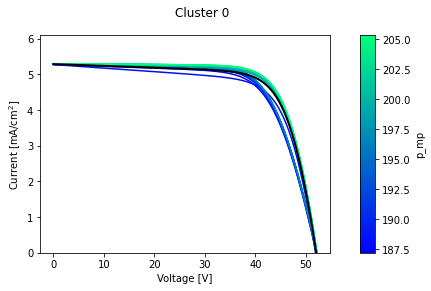

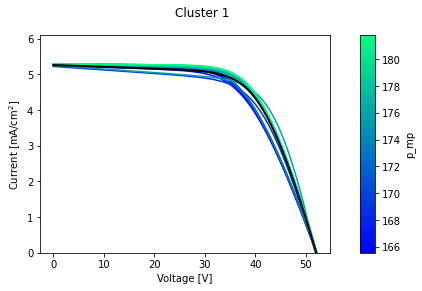

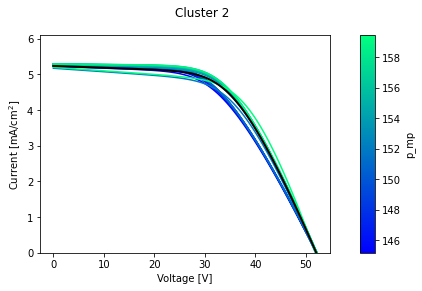

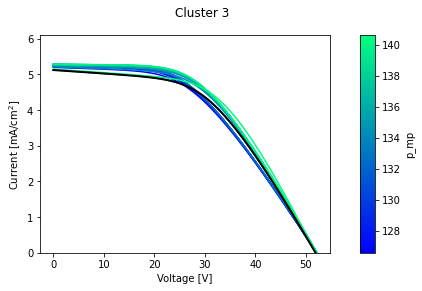

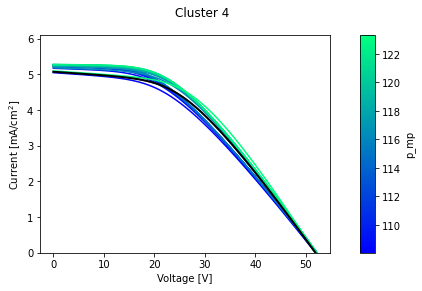

In [15]:
for c in range(n_clusters):
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [20, 1]})

    cluster = iv_data[iv_data['Ordered Cluster'] == c].sort_values(fitting_param)

    cmap = mpl.cm.winter
    ax[0].set_prop_cycle('color', [cmap(i) for i in np.linspace(0, 1, len(cluster))])
    norm = mpl.colors.Normalize(vmin=cluster[fitting_param].min(), vmax=cluster[fitting_param].max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    for cluster_params in cluster.index:
        ax[0].plot(cluster.loc[cluster_params, 'V'], cluster.loc[cluster_params, 'I'])

    ax[0].plot(iv_data.loc[clusters_info.loc[c, 'Params of Center'], 'V'], iv_data.loc[clusters_info.loc[c, 'Params of Center'], 'I'], c='black', linewidth=2)
    
    ax[0].set_ylim([0, iv_data['I'].apply(np.max).max() * 1.15])
    ax[0].set_xlabel('Voltage [V]')
    ax[0].set_ylabel('Current [mA/cm$^2$]')
    fig.suptitle(f'Cluster {c}')
    fig.colorbar(cmap, cax=ax[1], label=f'{fitting_param}')